In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("../")
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from src.train_pm import Dataset, double_conv, LeUNet, StandardNet, EnsembleNet, EPAPLN, ResNetUNet, EnsembleLeUNet
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from src.preprocessing.trans_func import *
import torchvision.models as models

In [2]:
data = pd.read_csv('../test_data.csv')
# data_train = data.sample(frac=0.8,random_state=17)
# data_val = data.loc[~data.index.isin(data_train.index)]
# files_train = list(data_train['filename'])
# files_val = list(data_val['filename'])
# ppm_train = list(data_train['ppm'])
# ppm_val = list(data_val['ppm'])
# ids_train = [i for i in range(len(files_train))]
# ids_val = [i for i in range(len(files_val))]
# data = None
# data_train = None
# data_val = None
files = list(data['filename'])
ppm = list(data['ppm'])
ids = [i for i in range(len(files))]

In [206]:
# model = LeUNet()
# model = torch.nn.DataParallel(model).cuda()
# model.load_state_dict(torch.load("../src/model_pm_train.pth"),strict=False) # on GPU

<All keys matched successfully>

In [4]:
# model = ResNetUNet()
# model = torch.nn.DataParallel(model).cuda()
# model.load_state_dict(torch.load("../src/resnetunet_pm_train.pth"),strict=False) # on GPU

In [242]:
# model = StandardNet('resnet50').cuda()
# model.load_state_dict(torch.load("../src/resnet50_pm_train.pth"),strict=False)

<All keys matched successfully>

In [278]:
# model = StandardNet('vgg16').cuda()
# model.load_state_dict(torch.load("../src/vgg16_pm_train.pth"),strict=False)

<All keys matched successfully>

In [134]:
# model = StandardNet('inception_v3').cuda()
# model.load_state_dict(torch.load("../src/inception_pm_train.pth"),strict=False)

/scratch/ab9738/chest/env_chest/lib/python3.8/site-packages/torchvision/models/inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


<All keys matched successfully>

In [314]:
model = EPAPLN().cuda()
model.load_state_dict(torch.load("../src/epapln_pm_train.pth"),strict=False)

<All keys matched successfully>

In [58]:
# model = EnsembleNet().cuda()
# model.load_state_dict(torch.load("../src/ensemble_pm_train.pth"),strict=False)

/scratch/ab9738/chest/env_chest/lib/python3.8/site-packages/torchvision/models/inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


<All keys matched successfully>

In [170]:
# model = EnsembleLeUNet().cuda()
# model.load_state_dict(torch.load("../src/ensembleleunet_pm_train.pth"),strict=False)

/scratch/ab9738/chest/env_chest/lib/python3.8/site-packages/torchvision/models/inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


<All keys matched successfully>

In [98]:
dataset = Dataset(ids, files, ppm, transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),transforms.Normalize(mean=[0.5231, 0.5180, 0.5115],std=[0.2014, 0.2018, 0.2100]),])) # normalize
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=12)

In [315]:
model = model.eval()

In [316]:
actual = []
preds = []
for x, y in loader:
    y = y.float()
    x = x.cuda(non_blocking=True)
    y = y.cuda(non_blocking=True)

    x_var = torch.autograd.Variable(x)
    y_var = torch.autograd.Variable(y)

    yhat = model(x_var).squeeze()
    actual += [y_var.cpu().detach().numpy()]
    preds += [yhat.cpu().detach().numpy()]

In [317]:
actual = np.concatenate(actual)

In [318]:
preds = np.concatenate(preds)

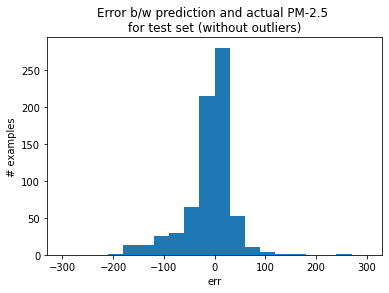

-10.545784
45.89123


In [319]:
err_test = np.array(preds)-np.array(actual)
plt.hist(err_test, bins=20,range=(-300,300))
plt.title("Error b/w prediction and actual PM-2.5 \nfor test set (without outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_full.png')
plt.show()
print(np.mean(err_test))
print(np.std(err_test))

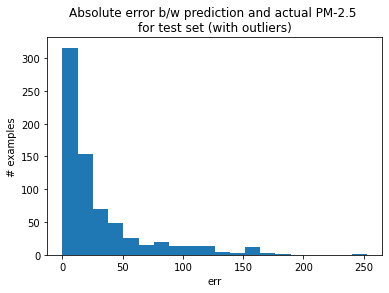

29.432114
36.75553


In [320]:
plt.hist(np.abs(err_test), bins=20)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_val.png')
plt.show()
print(np.mean(np.abs(err_test)))
print(np.std(np.abs(err_test)))

In [321]:
# plt.hist(np.abs(err_train), bins=20)
# plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor test set (with outliers)")
# plt.xlabel('err')
# plt.ylabel('# examples')
# plt.savefig('err_val.png')
# plt.show()
# print(np.mean(np.abs(err_train)))
# print(np.std(np.abs(err_train)))

In [322]:
id_china = []
id_delhi = []
for index, row in data.iterrows():
    filename = row['filename']
    if filename.startswith('Shanghai1') or filename.startswith('Shanghai2') or filename.startswith('Shanghai3') or filename.startswith('Beijing'):
        id_china.append(index)
    else:
        id_delhi.append(index)

print(len(id_china))
print(len(id_delhi))

446
267


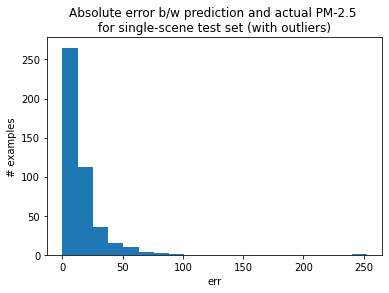

14.572981
18.499966


In [323]:
err_china = np.abs(err_test[np.array(id_china)]) #err_val,err?
err_delhi = np.abs(err_test[np.array(id_delhi)])
plt.hist(err_china, bins=20)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor single-scene test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_china.png')
plt.show()
print(np.mean(err_china))
print(np.std(err_china))

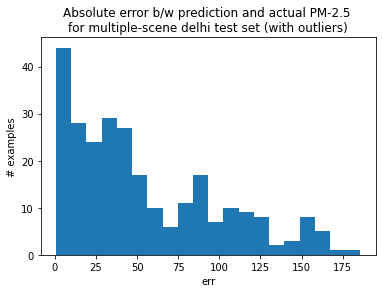

54.252983
45.288578


In [324]:
plt.hist(err_delhi, bins=20)
plt.title("Absolute error b/w prediction and actual PM-2.5 \nfor multiple-scene delhi test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_delhi.png')
plt.show()
print(np.mean(err_delhi))
print(np.std(err_delhi))

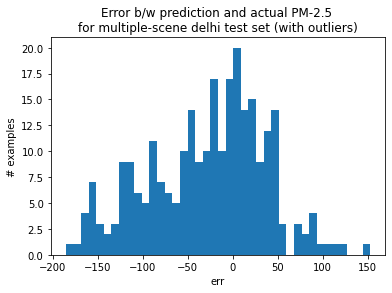

-28.737833
64.56454


In [325]:
plt.hist(err_test[np.array(id_delhi)], bins=40)
plt.title("Error b/w prediction and actual PM-2.5 \nfor multiple-scene delhi test set (with outliers)")
plt.xlabel('err')
plt.ylabel('# examples')
plt.savefig('err_delhi.png')
plt.show()
print(np.mean(err_test[np.array(id_delhi)]))
print(np.std(err_test[np.array(id_delhi)]))

In [326]:
actual_delhi = actual[np.array(id_delhi)]

In [327]:
preds_delhi = preds[np.array(id_delhi)]

In [328]:
correct_p = 0
for i in range(len(id_delhi)):
    if((preds_delhi[i]<actual_delhi[i]+25) and (preds_delhi[i]>actual_delhi[i]-25)):
        correct_p+=1
print(correct_p, len(id_delhi), correct_p*1.0/len(id_delhi))

91 267 0.3408239700374532


In [329]:
correct_p = 0
for i in range(len(id_delhi)):
    if((preds_delhi[i]<actual_delhi[i]+50) and (preds_delhi[i]>actual_delhi[i]-50)):
        correct_p+=1
print(correct_p, len(id_delhi), correct_p*1.0/len(id_delhi))

160 267 0.599250936329588


## Pollution Map

In [330]:
location_df = pd.read_csv("/scratch/ab9738/pollution_img/govdata/locations.csv")
location_df = location_df.drop(["source"], axis=1)

In [331]:
location_df['Lat-Lon'] = location_df['lat'].apply(str) +','+ location_df['lon'].apply(str)

In [332]:
location_df = location_df.drop(['lat', 'lon'], axis=1)

In [333]:
# Adding UP Sensor Locations
location_df.loc[len(location_df)] = ['SanjayNagar_UPPCP', '28.685382,77.453839']
location_df.loc[len(location_df)] = ['Indirapuram_UPPCP', '28.646233,77.358075']
location_df.loc[len(location_df)] = ['Vasundhara_UPPCP', '28.6603346,77.3572563']
location_df.loc[len(location_df)] = ['Loni_UPPCP', '28.757294,77.278792']
location_df.loc[len(location_df)] = ['NoidaSector62_IMD', '28.6245479,77.3577104']
location_df.loc[len(location_df)] = ['NoidaSector116_UPPCP', '28.56912141,77.3939069']
location_df.loc[len(location_df)] = ['KnowledgeParkV_UPPCP', '28.55856132,77.45445483']
location_df.loc[len(location_df)] = ['KnowledgeParkIII_UPPCP', '28.47250249,77.48179193']
location_df.loc[len(location_df)] = ['NoidaSector1_UPPCP', '28.58966084,77.30998866']
location_df.loc[len(location_df)] = ['NoidaSector125_UPPCP', '28.54492244,77.32281108']

In [334]:
location_df

,id,Lat-Lon
0,AshokVihar_DPCC,"28.695381,77.181665"
1,AyaNagar_IMD,"28.4706914,77.10993640000001"
2,BurariCrossing_IMD,"28.725650399999996,77.20115729999999"
3,CRRIMathuraRoad_IMD,"28.5512005,77.27357370000001"
4,DTU_CPCB,"28.7500499,77.1112615"
5,DwarkaSector8_DPCC,"28.5710274,77.07190059999999"
6,IGIAirport_IMD,"28.562776300000003,77.1180053"
7,IHBAS_CPCB,"28.681173600000005,77.30252340000001"
8,ITO_CPCB,"28.631694500000002,77.2494387"
9,Jahangirpuri_DPCC,"28.73282,77.170633"


In [335]:
df_act_preds = data.loc[id_delhi]

In [336]:
df_annot = pd.read_csv('/scratch/ab9738/pollution_img/code/Annotations.csv')

In [337]:
df_annot

,timestamp,latitude,longitude,filename,closest_dist,closest_monitor,closest_value
0,2022-01-20 19:09:49+05:30,28.552655,77.105907,20220120_190949___28.552655_77.105907___[org].jpg,1.630866,IGIAirport_IMD,189.82
1,2022-01-20 19:12:19+05:30,28.550738,77.120168,20220120_191219___28.550738_77.120168___[org].jpg,1.350866,IGIAirport_IMD,189.82
2,2022-01-20 19:13:26+05:30,28.553902,77.123568,20220120_191326___28.553902_77.123568___[org].jpg,1.124098,IGIAirport_IMD,189.82
3,2022-01-20 19:14:43+05:30,28.557050,77.132781,20220120_191443___28.55705_77.132781___[org].jpg,1.578941,IGIAirport_IMD,189.82
4,2022-01-20 19:15:28+05:30,28.561069,77.133684,20220120_191528___28.561069_77.133684___[org].jpg,1.545737,IGIAirport_IMD,189.82
...,...,...,...,...,...,...,...
377,2022-01-22 18:28:03+05:30,28.472070,77.487583,20220122_182803___28.47207_77.487583___[org].jpg,0.551466,KnowledgeParkIIIGreaterNoida_UPPCB,80.00
378,2022-01-22 18:28:39+05:30,28.474239,77.485458,20220122_182839___28.474239_77.485458___[org].jpg,0.378174,KnowledgeParkIIIGreaterNoida_UPPCB,80.00
379,2022-01-22 18:28:47+05:30,28.474239,77.485458,20220122_182847___28.474239_77.485458___[org].jpg,0.378174,KnowledgeParkIIIGreaterNoida_UPPCB,80.00
380,2022-01-22 18:29:04+05:30,28.475996,77.483764,20220122_182904___28.475996_77.483764___[org].jpg,0.402070,KnowledgeParkIIIGreaterNoida_UPPCB,80.00


In [338]:
df_annot['filename'] = df_annot['filename'].str[:-4]

In [339]:
df_annot = df_annot.set_index('filename')

In [340]:
df_act_preds['pred'] = preds_delhi

In [341]:
df_ap = df_act_preds.set_index('filename')

In [342]:
df_ap

,ppm,pred
filename,,
20220120_190949___28.552655_77.105907___[org],189.82,105.093979
20220120_191219___28.550738_77.120168___[org],189.82,102.884773
20220120_191326___28.553902_77.123568___[org],189.82,214.922028
20220120_191528___28.561069_77.133684___[org],189.82,106.155815
20220120_191554___28.563708_77.133846___[org],189.82,175.280212
...,...,...
20220122_182728___28.469431_77.489894___[org],80.00,111.917496
20220122_182741___28.470627_77.488803___[org],80.00,178.818726
20220122_182747___28.471369_77.488126___[org],80.00,110.307358


In [343]:
df_cm = df_annot['closest_monitor']

In [344]:
df_cm

filename
20220120_190949___28.552655_77.105907___[org]                        IGIAirport_IMD
20220120_191219___28.550738_77.120168___[org]                        IGIAirport_IMD
20220120_191326___28.553902_77.123568___[org]                        IGIAirport_IMD
20220120_191443___28.55705_77.132781___[org]                         IGIAirport_IMD
20220120_191528___28.561069_77.133684___[org]                        IGIAirport_IMD
                                                                ...                
20220122_182803___28.47207_77.487583___[org]     KnowledgeParkIIIGreaterNoida_UPPCB
20220122_182839___28.474239_77.485458___[org]    KnowledgeParkIIIGreaterNoida_UPPCB
20220122_182847___28.474239_77.485458___[org]    KnowledgeParkIIIGreaterNoida_UPPCB
20220122_182904___28.475996_77.483764___[org]    KnowledgeParkIIIGreaterNoida_UPPCB
20220122_182936___28.477578_77.482202___[org]    KnowledgeParkIIIGreaterNoida_UPPCB
Name: closest_monitor, Length: 382, dtype: object

In [345]:
df_ap = df_ap.merge(df_cm, on='filename')

In [346]:
df_ap = df_ap.groupby('closest_monitor').mean()

In [347]:
# df_ap.to_csv('pollution_map_input.csv')

In [348]:
abs(df_ap['ppm']-df_ap['pred']).mean()

35.42947462411245

In [349]:
(abs(df_ap['ppm']-df_ap['pred'])<50).sum()

14